# Imports

In [264]:
#SQL
import psycopg2
from credentials import HOST, DB, USR, PASS

#ETL
import pandas as pd
import numpy as np

#Gráficos
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns

#Miscellania
import missingno as msno
import warnings
from collections import Counter
from tqdm import tqdm

# Separação treino-teste-validação e tunagem de hiperparâmetros
from sklearn.model_selection import (train_test_split, 
                                     cross_validate, 
                                     cross_val_score,
                                     StratifiedKFold,
                                     RandomizedSearchCV)
from sklearn.feature_selection import RFE

# Balanceamento Dados
from imblearn.under_sampling import NearMiss, RandomUnderSampler
from imblearn.over_sampling import SMOTE

#Scalers
from sklearn.preprocessing import (StandardScaler, 
                                   MinMaxScaler,
                                   OrdinalEncoder, 
                                   OneHotEncoder, 
                                  MultiLabelBinarizer)

#Pipelines
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

#Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

#Métricas
from sklearn.metrics import (accuracy_score, 
                             roc_auc_score, 
                             precision_score, 
                             recall_score, 
                             f1_score, 
                             confusion_matrix,
                             plot_confusion_matrix,
                             plot_roc_curve,
                             roc_curve,
                             classification_report,
                             roc_auc_score,
                             SCORERS)

from sklearn.inspection import permutation_importance

import pickle

ImportError: cannot import name 'strip' from 'string' (/home/gabriel/anaconda3/envs/co2-env/lib/python3.10/string.py)

In [199]:
warnings.filterwarnings('ignore')
sns.set_style('darkgrid')
mpl.rcParams['figure.figsize'] = (12,6)

# Coleta de Dados

In [139]:
#Dados de conexão no banco
host     = HOST
db       = DB
usr      = USR
port     = '5432'
password = PASS

conn_string = f'host={host} user={usr} dbname={db} password ={password} port={port}'

In [5]:
# Estabelecer conexão com o banco
conn = psycopg2.connect(conn_string)

In [6]:
#Criação de cursor
cursor = conn.cursor()

#Query de coleta de todos dados
query = """SELECT DISTINCT f.*, o.id_pedido, o.status_pagamento, o.data_pedido,
            CASE WHEN o.status_pagamento is NULL THEN 0
                 WHEN o.status_pagamento = 'Cancelado' THEN 0
                 ELSE 1
                 END as target
            FROM forms f
            LEFT JOIN order_items oi
            ON f.id_form = oi.id_form
            LEFT JOIN orders o
            ON oi.id_pedido = o.id_pedido;"""

In [ ]:
cursor.execute(query)

In [ ]:
#Get rows
rows = cursor.fetchall()

In [ ]:
#Get Columns
cols = []
for col in cursor.description:
    cols.append(col[0])

In [ ]:
conn.close()

In [ ]:
cosmetics = pd.DataFrame(rows, columns = cols)

## Carregando base localmente

In [200]:
cosmetics = pd.read_csv('../data/dados_py.csv')

In [201]:
cosmetics.data = pd.to_datetime(cosmetics.data)

## Visualização dos dados

In [202]:
cosmetics.head()

,id_form,id_cliente,data,sistema_operacional,navegador,localizacao,locale,cidade,estado,qtde_lavagem_semana,...,faixa_etaria,efeitos_desejados,fragancia,id_pedido,status_pagamento,data_pedido,target,mes,rec_form,rec_compra
0,52a843d0b7e090a05fbf29dbc8b1a4,755e5d5efaa0de273687,2022-01-01 00:13:01,Android,Chrome,"Curitiba, Parana",BR,CURITIBA,PARANA,2,...,18 a 24,"Efeito 6, Efeito 2, Efeito 4, Efeito 3, Efeito 1",Rosas,NaN,NaN,NaN,0,1,0,0
1,0eec183ffa8b5ea2b50bad7247ef7a,af4f02a79c7f0a318dd3,2022-01-01 00:16:14,Android,Chrome,"Curitiba, Parana",BR,CURITIBA,PARANA,4,...,11 a 17,"Efeito 6, Efeito 7, Efeito 4, Efeito 1",Flores do campo,NaN,NaN,NaN,0,1,0,0
2,1c35d70c95b2d2c8f6be4ff6f84b96,67d9e56f53f9fb49af6f,2022-01-01 00:17:06,Android,Chrome,"Montes Claros, Minas Gerais",BR,MONTES CLAROS,MINAS GERAIS,1,...,18 a 24,"Efeito 6, Efeito 7, Efeito 8, Efeito 1, Efeito 5",Eucalipto,NaN,NaN,NaN,0,1,0,0
3,593a259a51f2f00a15db33946d6d65,e0d69ea9eb3a130f5766,2022-01-01 00:17:14,iOS,NaN,"São Paulo, Sao Paulo",BR,SÃO PAULO,SAO PAULO,5,...,45 a 54,"Efeito 1, Efeito 5, Efeito 7, Efeito 8",Rosas,NaN,NaN,NaN,0,1,0,0
4,44f20b125e4971eca764ccc4dadfcd,d687ea972ccb5373c605,2022-01-01 00:24:01,Android,Chrome,"Curitiba, Parana",BR,CURITIBA,PARANA,2,...,18 a 24,"Efeito 6, Efeito 2, Efeito 4, Efeito 3, Efeito 1",Rosas,NaN,NaN,NaN,0,1,0,0


In [203]:
cosmetics.shape

(419832, 30)

In [204]:
cosmetics.columns

Index(['id_form', 'id_cliente', 'data', 'sistema_operacional', 'navegador',
       'localizacao', 'locale', 'cidade', 'estado', 'qtde_lavagem_semana',
       'utm_source', 'tipo_cabelo', 'comprimento', 'tipo_fios',
       'procedimentos', 'tempo_procedimento', 'dieta', 'atividade_fisica',
       'frequencia_estresse', 'caracteristica', 'faixa_etaria',
       'efeitos_desejados', 'fragancia', 'id_pedido', 'status_pagamento',
       'data_pedido', 'target', 'mes', 'rec_form', 'rec_compra'],
      dtype='object')

* O dataset contém todas as informações disponibilizadas pelo formulário que serão consideradas como as principais features para o modelo e algumas informações sobre os pedidos para possíveis ajustes nos dados que possam contribuir com o poder preditivo do modelo como o status de pagamento e data do pedido.

* A informação de compra foi traduzida na feature **target** que indica se o lead realizou um pedido (1) ou não (0) após preencher o formulário.

* Há casos onde um único formulário foi utilizado em vários pedidos. Nesse caso, esses pedidos serão considerados como duplicatas e serão contabilizados apenas uma vez.

In [159]:
#Salvando a base 
cosmetics.to_csv('../data/dados_py.csv', index = False)

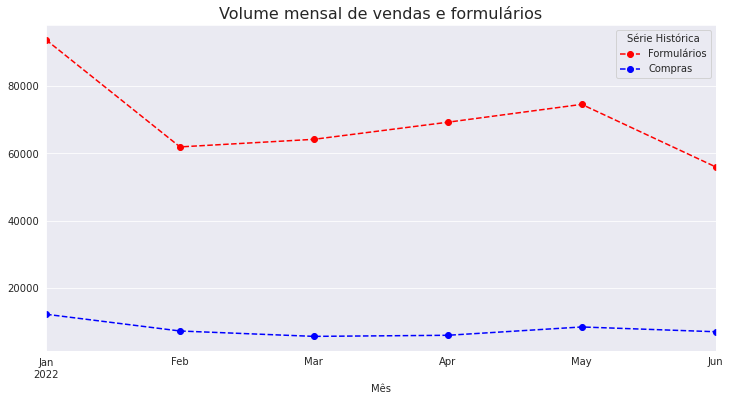

In [196]:
forms  = cosmetics.set_index('data').resample('M').count()['id_form'].plot(marker = 'o', label = 'forms', linestyle = '--', color = 'r')
vendas = cosmetics.set_index('data')[cosmetics.set_index('data').target == 1].resample('M').count()['id_form'].plot(marker = 'o', label='compra',color = 'blue', linestyle = '--')
plt.legend(['Formulários','Compras'], title = 'Série Histórica')
plt.title('Volume mensal de vendas e formulários', fontsize = 16)
plt.xlabel('Mês')
plt.show()

## Estimativa de volume mensal de formulários

In [205]:
cosmetics.sort_values(by='data', inplace = True)

In [206]:
cosmetics.data = pd.to_datetime(cosmetics.data)

In [207]:
cosmetics['mes'] = cosmetics.data.dt.month

In [208]:
cosmetics.groupby('mes')['id_form'].count()

mes
1    93799
2    61944
3    64203
4    69292
5    74602
6    55992
Name: id_form, dtype: int64

In [209]:
cosmetics.groupby('mes')['id_form'].count().mean()

69972.0

Em média são realizados cerca de 72 mil formulários ao mês.

## Filtrando formulários 

In [210]:
cosmetics.status_pagamento.value_counts()

Entregue              33778
Pagamento aprovado     9352
Em transporte          2893
Name: status_pagamento, dtype: int64

Assumiu-se que pedidos 'Entregue', 'Em transporte' e 'Pagamento confirmado' constituem compras bem sucedidas. Como a base contem mais de 400 mil dados disponívis, pedidos cancelados e aguardando pagamento serão retirados do dataset.


In [211]:
cosmetics = cosmetics[(cosmetics.status_pagamento != 'Cancelado') & (cosmetics.status_pagamento != 'Aguardando pagamento') & (cosmetics.status_pagamento != 'Criado')]

## Feature de recorrencia

In [13]:
recorrencia_forms  = []
recorrencia_compra = []
for n, row in tqdm(cosmetics.iterrows()):
    recorrencia_forms.append(len(cosmetics.iloc[:n][cosmetics.id_cliente == row.id_cliente]))
    recorrencia_compra.append(len(cosmetics.iloc[:n][(cosmetics.id_cliente == row.id_cliente) & (cosmetics.target == 1)]))

419832it [10:17:50, 11.33it/s]


In [15]:
cosmetics['rec_form']   = recorrencia_forms
cosmetics['rec_compra'] =  recorrencia_compra

In [212]:
cosmetics

,id_form,id_cliente,data,sistema_operacional,navegador,localizacao,locale,cidade,estado,qtde_lavagem_semana,...,faixa_etaria,efeitos_desejados,fragancia,id_pedido,status_pagamento,data_pedido,target,mes,rec_form,rec_compra
0,52a843d0b7e090a05fbf29dbc8b1a4,755e5d5efaa0de273687,2022-01-01 00:13:01,Android,Chrome,"Curitiba, Parana",BR,CURITIBA,PARANA,2,...,18 a 24,"Efeito 6, Efeito 2, Efeito 4, Efeito 3, Efeito 1",Rosas,NaN,NaN,NaN,0,1,0,0
1,0eec183ffa8b5ea2b50bad7247ef7a,af4f02a79c7f0a318dd3,2022-01-01 00:16:14,Android,Chrome,"Curitiba, Parana",BR,CURITIBA,PARANA,4,...,11 a 17,"Efeito 6, Efeito 7, Efeito 4, Efeito 1",Flores do campo,NaN,NaN,NaN,0,1,0,0
2,1c35d70c95b2d2c8f6be4ff6f84b96,67d9e56f53f9fb49af6f,2022-01-01 00:17:06,Android,Chrome,"Montes Claros, Minas Gerais",BR,MONTES CLAROS,MINAS GERAIS,1,...,18 a 24,"Efeito 6, Efeito 7, Efeito 8, Efeito 1, Efeito 5",Eucalipto,NaN,NaN,NaN,0,1,0,0
3,593a259a51f2f00a15db33946d6d65,e0d69ea9eb3a130f5766,2022-01-01 00:17:14,iOS,NaN,"São Paulo, Sao Paulo",BR,SÃO PAULO,SAO PAULO,5,...,45 a 54,"Efeito 1, Efeito 5, Efeito 7, Efeito 8",Rosas,NaN,NaN,NaN,0,1,0,0
4,44f20b125e4971eca764ccc4dadfcd,d687ea972ccb5373c605,2022-01-01 00:24:01,Android,Chrome,"Curitiba, Parana",BR,CURITIBA,PARANA,2,...,18 a 24,"Efeito 6, Efeito 2, Efeito 4, Efeito 3, Efeito 1",Rosas,NaN,NaN,NaN,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
419827,1d079f0da7c372a0b46176eb6df28f,f8899992e2a012971935,2022-06-30 23:49:30,Android,Chrome,"Porto Alegre, Rio Grande do Sul",BR,PORTO ALEGRE,RIO GRANDE DO SUL,4,...,65+,Efeito 6,Eucalipto,NaN,NaN,NaN,0,6,1,0
419828,d24aa939eb8631e4ebfd19a41f3f26,1e746654168e20b6b695,2022-06-30 23:53:26,iOS,Safari,"Hortolândia, Sao Paulo",BR,HORTOLÂNDIA,SAO PAULO,4,...,25 a 34,"Efeito 6, Efeito 7, Efeito 8, Efeito 1",Rosas,NaN,NaN,NaN,0,6,2,0
419829,44dc276981466895404748486c6294,a6694c23b639809720a5,2022-06-30 23:55:20,iOS,NaN,"Paulista, Pernambuco",BR,PAULISTA,PERNAMBUCO,2,...,25 a 34,"Efeito 6, Efeito 2, Efeito 7, Efeito 1, Efeito 3",Eucalipto,NaN,NaN,NaN,0,6,3,1
419830,d6839000a882376fc4847f33d24e14,644e4b7a42c80a30d632,2022-06-30 23:57:32,iOS,Safari,"Cotia, Sao Paulo",BR,COTIA,SAO PAULO,4,...,25 a 34,"Efeito 7, Efeito 8, Efeito 4",Flores do campo,NaN,NaN,NaN,0,6,1,0


## Criação de dataset apenas com features que serão consideradas para a modelagem

In [295]:
#Drop de colunas de ID e data
df = cosmetics.drop(['id_form','id_cliente','data','data_pedido','id_pedido', 'status_pagamento','mes'], axis = 1)

In [296]:
df.columns

Index(['sistema_operacional', 'navegador', 'localizacao', 'locale', 'cidade',
       'estado', 'qtde_lavagem_semana', 'utm_source', 'tipo_cabelo',
       'comprimento', 'tipo_fios', 'procedimentos', 'tempo_procedimento',
       'dieta', 'atividade_fisica', 'frequencia_estresse', 'caracteristica',
       'faixa_etaria', 'efeitos_desejados', 'fragancia', 'target', 'rec_form',
       'rec_compra'],
      dtype='object')

In [297]:
df.head()

,sistema_operacional,navegador,localizacao,locale,cidade,estado,qtde_lavagem_semana,utm_source,tipo_cabelo,comprimento,...,dieta,atividade_fisica,frequencia_estresse,caracteristica,faixa_etaria,efeitos_desejados,fragancia,target,rec_form,rec_compra
0,Android,Chrome,"Curitiba, Parana",BR,CURITIBA,PARANA,2,linktree,Tipo 2,Raíz exposta,...,Celíaca,Raramente,Uma vez por mês,Característica 1,18 a 24,"Efeito 6, Efeito 2, Efeito 4, Efeito 3, Efeito 1",Rosas,0,0,0
1,Android,Chrome,"Curitiba, Parana",BR,CURITIBA,PARANA,4,influencer,Tipo 2,Muito curto,...,Celíaca,Frequente,Nunca,Característica 7,11 a 17,"Efeito 6, Efeito 7, Efeito 4, Efeito 1",Flores do campo,0,0,0
2,Android,Chrome,"Montes Claros, Minas Gerais",BR,MONTES CLAROS,MINAS GERAIS,1,google,Tipo 2,Raíz exposta,...,Celíaca,Raramente,Uma vez por mês,Característica 3,18 a 24,"Efeito 6, Efeito 7, Efeito 8, Efeito 1, Efeito 5",Eucalipto,0,0,0
3,iOS,NaN,"São Paulo, Sao Paulo",BR,SÃO PAULO,SAO PAULO,5,facebook,Tipo 1,Muito curto,...,Celíaca,Raramente,Uma vez por mês,Característica 2,45 a 54,"Efeito 1, Efeito 5, Efeito 7, Efeito 8",Rosas,0,0,0
4,Android,Chrome,"Curitiba, Parana",BR,CURITIBA,PARANA,2,linktree,Tipo 2,Raíz exposta,...,Celíaca,Raramente,Uma vez por mês,Característica 1,18 a 24,"Efeito 6, Efeito 2, Efeito 4, Efeito 3, Efeito 1",Rosas,0,0,0


In [298]:
df.shape

(419832, 23)

Filtrando formularios apenas de estados com mais de 100 pedidos

In [299]:
df['count_estado'] = df.groupby('estado')['navegador'].transform('count')

In [300]:
df.estado.value_counts()

 SAO PAULO              134075
 MINAS GERAIS            38412
 RIO DE JANEIRO          36177
 PARANA                  26272
 RIO GRANDE DO SUL       21344
                         ...  
 TRENTINO-ALTO ADIGE         1
 TOKYO                       1
 TELANGANA                   1
 ANTIOQUIA                   1
 NEW BRUNSWICK               1
Name: estado, Length: 324, dtype: int64

In [301]:
df = df[df['count_estado'] > 100].drop('count_estado',axis = 1)

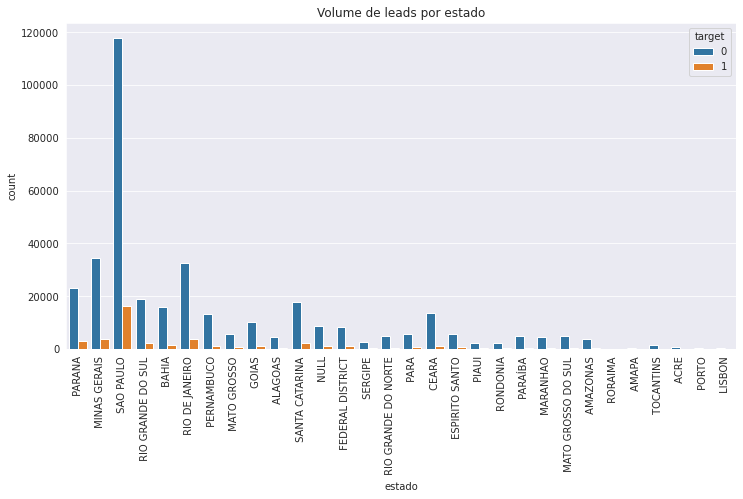

In [220]:
plt.figure(figsize =(12,6))
plt.title('Volume de leads por estado')
sns.countplot(data = df, x='estado', hue = 'target')

plt.xticks(rotation = 90)
plt.show()

# Avaliação de variáveis categóricas

In [304]:
df.select_dtypes('object').nunique().sort_values(ascending = False)

efeitos_desejados      11765
localizacao             4622
cidade                  4324
caracteristica          1928
procedimentos             66
utm_source                38
estado                    30
faixa_etaria               8
navegador                  8
sistema_operacional        6
atividade_fisica           5
tempo_procedimento         5
frequencia_estresse        4
tipo_fios                  4
dieta                      4
comprimento                4
tipo_cabelo                4
fragancia                  3
locale                     1
dtype: int64

# Formatação features

Será feita uma avaliação inicial das features para verificar se o significados das valores pode contribuir para otimizar o processo de modelagem

In [305]:
cat_m10 = (df.select_dtypes('object').nunique() < 10)[(df.select_dtypes('object').nunique() < 10)].index

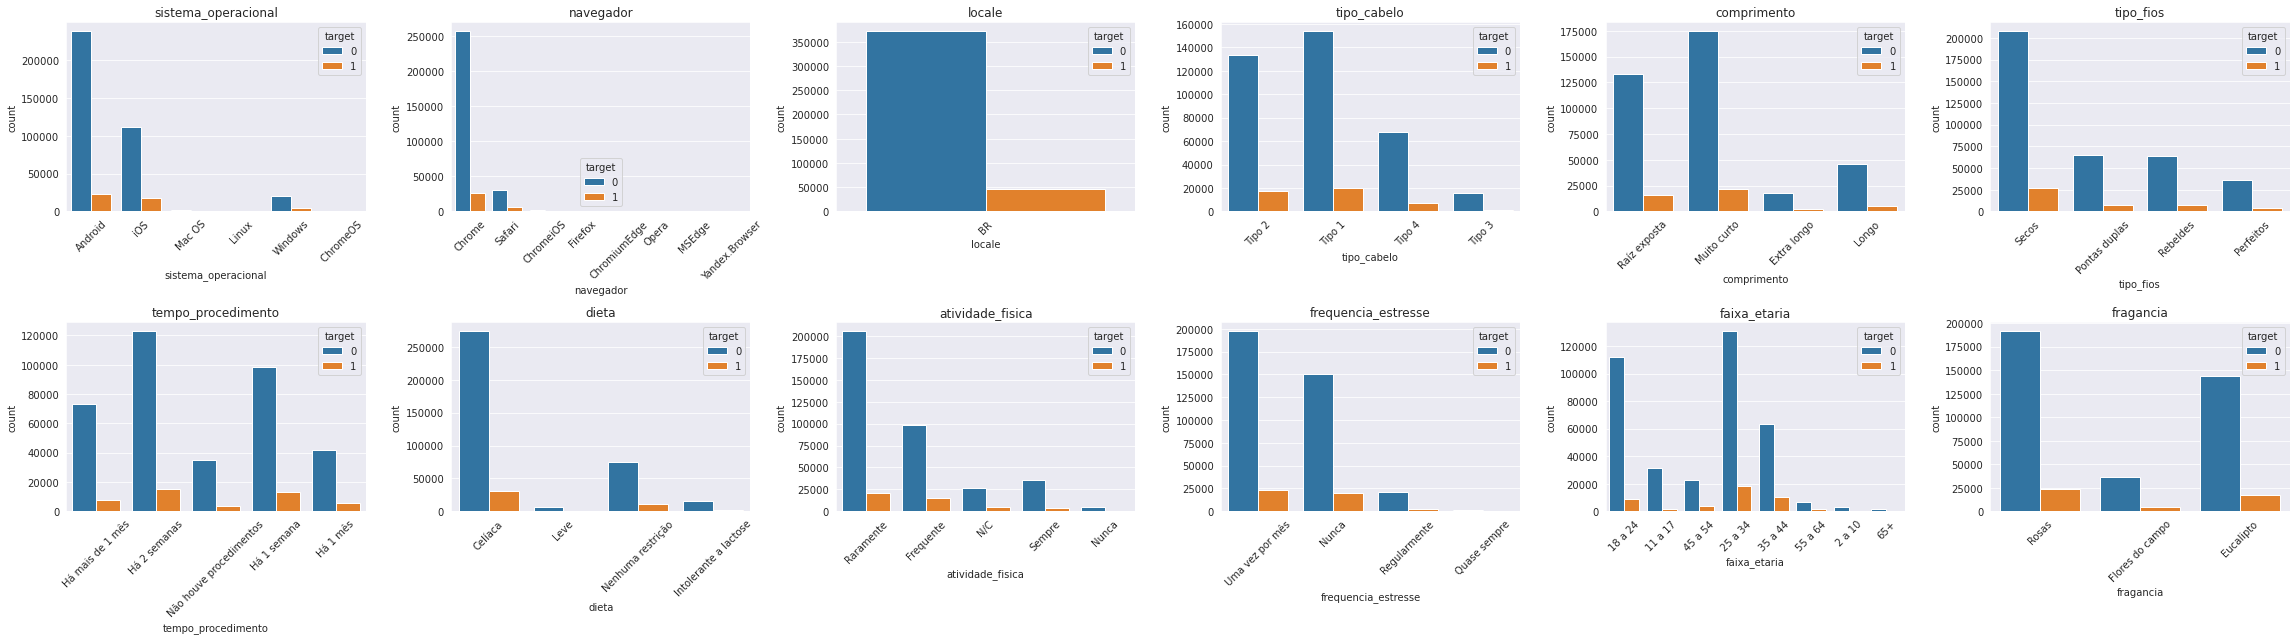

In [306]:
f, ax = plt.subplots(figsize=(32,9), nrows=2, ncols = int(len(cat_m10)/2))
c=0
l=0
for catcol in cat_m10:
    sns.countplot(x=catcol, data = df, hue = 'target', ax = ax[l][c])
    ax[l][c].tick_params(axis='x', rotation=45)
    ax[l][c].set_title(catcol)
    if c<len(cat_m10)/2-1:
        c+=1
    else:
        c=0
        l+=1
        
plt.tight_layout()

* A maior parte dos clientes acessa a plataforma por celular via Android ou iOS, utilizando como navegador, principalmente Chrome e Safari.
* A distribuição da target é semelhantes entre as categorias das features plotadas
* A fragancia mais pedida é a de rosas seguida pela de eucalipto
* Os leads gerados estão concentrados na faixa etária de 18 a 34 anos.
* A maior parte dos formulários é preenchdia por clientes que pratica pouca atividade física
* A maior parte da base clientes é celíaco.
* O comprimento dos cabelos descritos é, em sua maioria, de raíz exposta ou muito curto e de fios secos.

In [307]:
# FEATURE LOCALE
df.locale.value_counts()

BR    417142
Name: locale, dtype: int64

In [308]:
#Coluna sem variabilidade será dropada
df.drop('locale', axis = 1, inplace = True)

In [309]:
# FEATURE LOCALIZACAO
df.localizacao.value_counts()

São Paulo, Sao Paulo              51624
Rio de Janeiro, Rio de Janeiro    19051
Belo Horizonte, Minas Gerais      10583
null, null                         9821
Brasília, Federal District         9319
                                  ...  
Cachoeira do Arari, Para              1
Julio Borges, Piaui                   1
Montividiu do Norte, Goias            1
Rio Tinto, Paraíba                    1
Tejupa, Sao Paulo                     1
Name: localizacao, Length: 4622, dtype: int64

In [310]:
# Mesma info de cidade e estado, portanto será dropada.
df.drop('localizacao', axis =1, inplace = True)

efeitos_desejados     OK 
cidade                OK               
caracteristica        OK 
estado                OK              
procedimentos         OK    
utm_source            OK

In [311]:
#Feature utm_source
df.utm_source.value_counts().sort_index()

Facebook ads            1
IGShopping           2960
adwords               723
all                     1
blog                 1302
copy_link               1
cpc                     4
email                   1
email_sf             1631
facebook            98107
facebook                3
google              35654
incicacao              65
influencer         126876
instagram           20438
linktree            23339
meliuz                 60
microinfluencer       766
popup                   2
rakuten              3068
salesforce             42
santander               1
sendinblue             19
sf_                     1
sf_camp_email           2
sf_email_camp       13997
sf_email_flux         327
sf_sms_camp            10
sf_wpp_camp         23956
sf_wpp_flu              4
sf_wpp_flux          8559
site                  605
sms                     4
telegram               17
teste_source            1
tiktok                963
uaubox                  2
whatsapp               24
Name: utm_so

* Canal por onde o cliente chegou até a empresa
* sf_wpp_flu e sf_wpp_flux devem ser o mesmo tipo
* facebook duplicado
* Vários grupos são semelhantes mas estão segmentados como email, whatsapp, facebook, salesforce

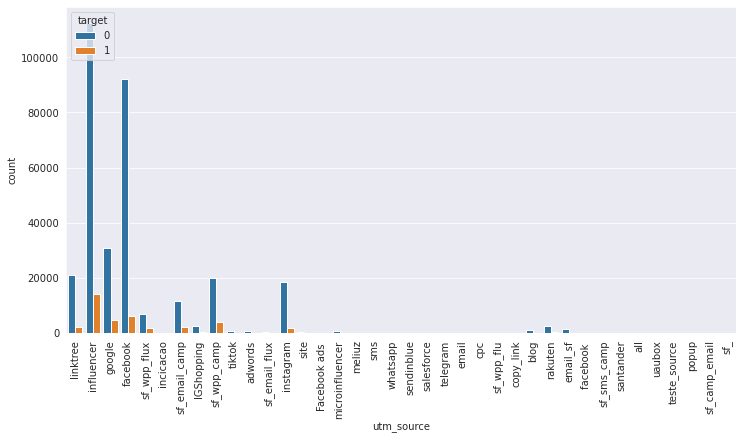

In [312]:
sns.countplot(data=df, x='utm_source',hue = 'target')
plt.xticks(rotation = 90)
plt.show()

In [313]:
#Feature Procedimentos
df.procedimentos.value_counts() 

Corte agressivo                                       77776
Todos acima                                           67556
Tintura                                               37480
Exposição ao sol                                      33605
Tintura, Corte agressivo                              32510
                                                      ...  
Corte agressivo, Exposição ao sol, Tintura, Nenhum      135
Exposição ao sol, Tintura, Nenhum                       120
Exposição ao sol, Corte agressivo, Nenhum, Tintura      116
Exposição ao sol, Tintura, Nenhum, Corte agressivo       87
N/C                                                       3
Name: procedimentos, Length: 66, dtype: int64

* Tipo de ação procedimento pelo qual o cabelo passou
* Agrupamento de valores em checklist

In [314]:
df.caracteristica.value_counts()

Característica 3                                                                             113522
Característica 7                                                                              45441
Característica 1                                                                              39830
Característica 3, Característica 8                                                            35497
Característica 8                                                                              17655
                                                                                              ...  
Característica 1, Característica 6, Característica 3, Característica 8, Característica 10         1
Característica 1, Característica 3, Característica 10, Característica 9, Característica 2         1
Característica 3, Característica 4, Característica 10, Característica 8, Característica 1         1
Característica 3, Característica 4, Característica 6, Característica 10                           1


* Características pré-determinadas do cabelo 
* Agrupamento de valores em checklist

In [315]:
df.efeitos_desejados.value_counts()

Efeito 6, Efeito 7, Efeito 4, Efeito 3               6017
Efeito 6, Efeito 7, Efeito 8, Efeito 4, Efeito 3     5801
Efeito 6, Efeito 7, Efeito 8, Efeito 4               5162
Efeito 7                                             4617
Efeito 6, Efeito 2, Efeito 4, Efeito 3               3917
                                                     ... 
Efeito 10, Efeito 3, Efeito 4, Efeito 2, Efeito 1       1
Efeito 10, Efeito 2, Efeito 3, Efeito 4, Efeito 7       1
Efeito 3, Efeito 5, Efeito 2, Efeito 8, Efeito 1        1
Efeito 4, Efeito 1, Efeito 7, Efeito 2, Efeito 10       1
Efeito 8, Efeito 10, Efeito 6, Efeito 1, Efeito 7       1
Name: efeitos_desejados, Length: 11765, dtype: int64

* Efeitos a serem aplicados no cabelo pelo produto
* Agrupamento de valores em checklist

# Avaliação de variáveis Numéricas

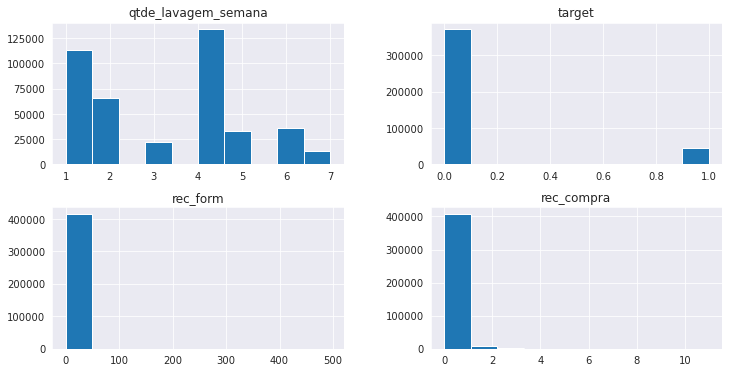

In [316]:
df.hist(figsize = (12,6))
plt.show()

## Avaliação Target

In [317]:
df.target.value_counts()

0    371326
1     45816
Name: target, dtype: int64

In [318]:
df.target.value_counts(normalize = True)

0    0.890167
1    0.109833
Name: target, dtype: float64

In [319]:
# Conversão para binário
df.target = df.target.astype('int')

# Valores Missing

In [320]:
df.isna().sum()

sistema_operacional        0
navegador              90152
cidade                 13606
estado                     0
qtde_lavagem_semana        0
utm_source             53606
tipo_cabelo                0
comprimento                0
tipo_fios                  0
procedimentos              0
tempo_procedimento         0
dieta                      0
atividade_fisica           0
frequencia_estresse        0
caracteristica             0
faixa_etaria               0
efeitos_desejados        946
fragancia                  0
target                     0
rec_form                   0
rec_compra                 0
dtype: int64

In [321]:
df.dropna(axis=0, subset='estado', inplace = True)

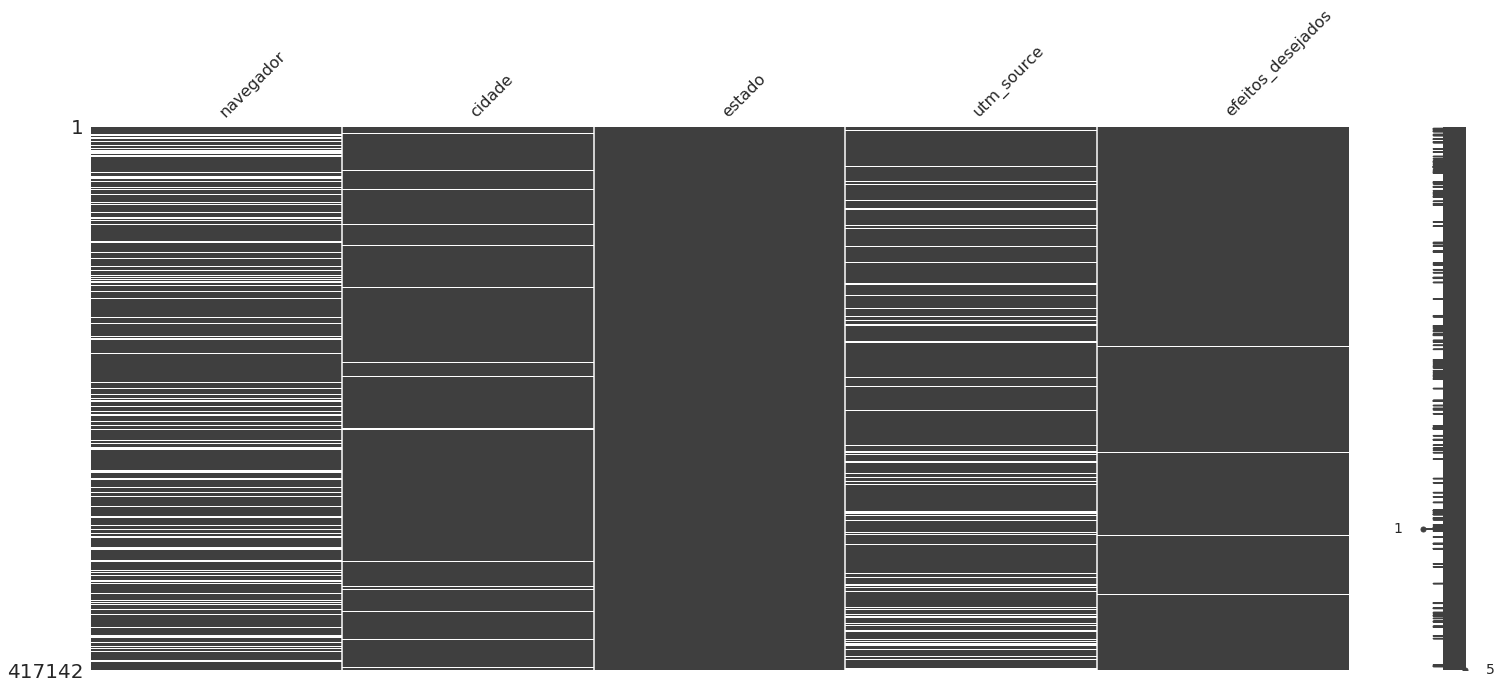

In [322]:
msno.matrix(df[['navegador','cidade','estado','utm_source','efeitos_desejados']])
plt.show()

* Na coluna navegador, como são muitos valores, pode ser mais conveniente retirar a coluna inteira
* No caso de cidade e estado, há chance de não serem features relevantes para o modelo
* Efeitos desejados nulos podem ser substituídos por 0
* Status do pagamento faltante apenas que o pedido nao foi realizado apesar do preenchimento do formulário, não será utilizado.

In [323]:
df.dropna(axis = 0, subset='efeitos_desejados', inplace = True)

# Valores Duplicados

In [324]:
cosmetics.duplicated().sum()

0

In [325]:
df.duplicated().sum()

3041

In [326]:
df.drop_duplicates(inplace = True)

# Feature Engineering (1)

O tratamento aqui aplicado a essas features deve também ser implementado durante o deploy da aplicação para que estas features possam ser avaliadas na predição.

## Efeitos desejados

In [327]:
df.efeitos_desejados.value_counts()

Efeito 6, Efeito 7, Efeito 4, Efeito 3               5927
Efeito 6, Efeito 7, Efeito 8, Efeito 4, Efeito 3     5669
Efeito 6, Efeito 7, Efeito 8, Efeito 4               5087
Efeito 7                                             4562
Efeito 6, Efeito 2, Efeito 4, Efeito 3               3867
                                                     ... 
Efeito 5, Efeito 3, Efeito 7, Efeito 8, Efeito 6        1
Efeito 1, Efeito 4, Efeito 7, Efeito 10, Efeito 3       1
Efeito 2, Efeito 1, Efeito 5, Efeito 10, Efeito 3       1
Efeito 10, Efeito 4, Efeito 2, Efeito 3                 1
Efeito 8, Efeito 10, Efeito 6, Efeito 1, Efeito 7       1
Name: efeitos_desejados, Length: 11765, dtype: int64

In [328]:
# Separação de efeitos por cliente em lista
df.efeitos_desejados = df.efeitos_desejados.apply(lambda x: sorted(x.split(',')) if x != 0 else 0)

In [329]:
df.efeitos_desejados = df.efeitos_desejados.apply(lambda x: list(map(str.strip, x)))

In [330]:
df['n_efeitos'] = df.efeitos_desejados.apply(lambda x: len(x) if type(x) == list else 0)

In [331]:
# Função para coletar todas as possibilidades de resultado dentro da coluna
def listar_unicos(efeitos, lista_unique):
    if efeitos == 0:
        return
    for efeito in efeitos:
        n_efeito = efeito.split(' ')[-1]
        lista_unique.add(n_efeito)
            

In [332]:
todos_efeitos = set()
df.efeitos_desejados.apply(listar_unicos, args = [todos_efeitos])

0         None
1         None
2         None
3         None
5         None
          ... 
419827    None
419828    None
419829    None
419830    None
419831    None
Name: efeitos_desejados, Length: 413155, dtype: object

In [333]:
#Todos os efeitos possíveis
todos_efeitos

{'1', '10', '2', '3', '4', '5', '6', '7', '8', 'N/C'}

Apesar da lista nao conter o efeito 9, pode ser devido a uma deficiencia no dataset mas que a característica seja válida. Portanto, será incluída entre as features dos dados.

In [334]:
multi_efeitos = MultiLabelBinarizer()

In [335]:
(multi.fit_transform(df['efeitos_desejados'])).shape

(413155, 10)

In [58]:
def col_efeito(efeitos, label):
    if efeitos == 0:
        return 0
    elif label in efeitos:
        return 1
    else:
        return 0

In [59]:
df['efeito1']  = df.efeitos_desejados.apply(col_efeito, args = ['Efeito 1'])
df['efeito2']  = df.efeitos_desejados.apply(col_efeito, args = ['Efeito 2'])
df['efeito3']  = df.efeitos_desejados.apply(col_efeito, args = ['Efeito 3'])
df['efeito4']  = df.efeitos_desejados.apply(col_efeito, args = ['Efeito 4'])
df['efeito5']  = df.efeitos_desejados.apply(col_efeito, args = ['Efeito 5'])
df['efeito6']  = df.efeitos_desejados.apply(col_efeito, args = ['Efeito 6'])
df['efeito7']  = df.efeitos_desejados.apply(col_efeito, args = ['Efeito 7']) 
df['efeito8']  = df.efeitos_desejados.apply(col_efeito, args = ['Efeito 8'])
df['efeito9']  = df.efeitos_desejados.apply(col_efeito, args = ['Efeito 9'])
df['efeito10'] = df.efeitos_desejados.apply(col_efeito, args = ['Efeito 10'])

<AxesSubplot:>

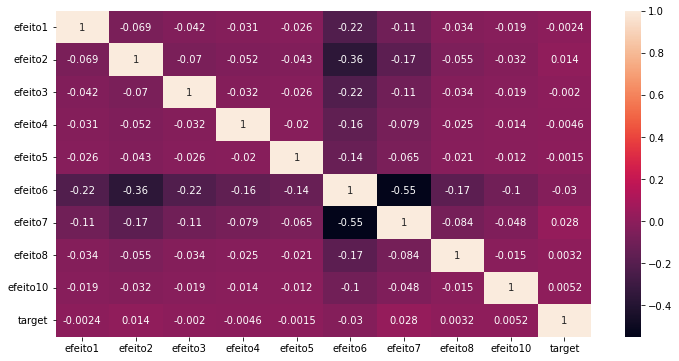

In [62]:
# Avaliando a correlação entre os efeitos e a variável target
plt.figure(figsize = (12,6))
sns.heatmap(df.loc[:,['efeito1', 'efeito2', 'efeito3', 'efeito4', 'efeito5', 'efeito6', 'efeito7', 'efeito8', 'efeito10', 'target']].corr(), annot = True)

## Características

In [294]:
df.caracteristica.value_counts()

[Característica 3]                                                                                               112481
[Característica 7]                                                                                                44863
[Característica 1]                                                                                                39329
[Característica 3, Característica 8]                                                                              35266
[Característica 8]                                                                                                17487
                                                                                                                  ...  
[Característica 10, Característica 4, Característica 9, Característica 1, Característica 8]                           1
[Característica 8, Característica 4, Característica 6]                                                                1
[Característica 9, Característica 4, Car

In [280]:
# Separação de caracteristica por cliente em lista
df.caracteristica = df.caracteristica.apply(lambda x: x.split(',') if x != 0 else 0)

In [281]:
df.caracteristica = df.caracteristica.apply(lambda x: list(map(str.strip, x)))

In [283]:
df['n_caracteristicas'] = df.caracteristica.apply(lambda x: len(x) if type(x) == list else 0)

In [ ]:
todas_caracteristicas= set()
df.caracteristica.apply(listar_unicos, args = [todas_caracteristicas])

0         None
1         None
2         None
3         None
5         None
          ... 
431109    None
431110    None
431111    None
431112    None
431113    None
Name: caracteristica, Length: 413155, dtype: object

In [288]:
multi_carac = MultiLabelBinarizer()
(multi_carac.fit_transform(df.caracteristica)).shape

(413155, 11)

In [284]:
todas_caracteristicas

{'1', '10', '2', '3', '4', '5', '6', '7', '8', '9', 'N/C'}

## Procedimentos

In [336]:
df.procedimentos.value_counts() 

Corte agressivo                                       76843
Todos acima                                           66767
Tintura                                               36981
Exposição ao sol                                      33177
Tintura, Corte agressivo                              32224
                                                      ...  
Corte agressivo, Exposição ao sol, Tintura, Nenhum      135
Exposição ao sol, Tintura, Nenhum                       120
Exposição ao sol, Corte agressivo, Nenhum, Tintura      116
Exposição ao sol, Tintura, Nenhum, Corte agressivo       87
N/C                                                       3
Name: procedimentos, Length: 66, dtype: int64

In [337]:
df.procedimentos = df.procedimentos.apply(lambda x: x.split(',') if x != 0 else 0)

In [338]:
df.procedimentos

0              [Todos acima]
1              [Todos acima]
2          [Corte agressivo]
3              [Todos acima]
5         [Exposição ao sol]
                 ...        
419827    [Exposição ao sol]
419828         [Todos acima]
419829     [Corte agressivo]
419830     [Corte agressivo]
419831              [Nenhum]
Name: procedimentos, Length: 413155, dtype: object

In [ ]:
def listar_unicos_2(proceds, lista_unique):
    for proced in proceds:
        lista_unique.add(proced.strip())

In [ ]:
todos_proceds = set()
df.procedimentos.apply(listar_unicos_2, args = [todos_proceds])

0         None
1         None
2         None
3         None
5         None
          ... 
431109    None
431110    None
431111    None
431112    None
431113    None
Name: procedimentos, Length: 413155, dtype: object

In [341]:
df.procediimentos = df.procedimentos.apply(lambda x: list(map(str.strip, x)))

In [342]:
df.procedimentos

0              [Todos acima]
1              [Todos acima]
2          [Corte agressivo]
3              [Todos acima]
5         [Exposição ao sol]
                 ...        
419827    [Exposição ao sol]
419828         [Todos acima]
419829     [Corte agressivo]
419830     [Corte agressivo]
419831              [Nenhum]
Name: procedimentos, Length: 413155, dtype: object

In [344]:
multi_proceds = MultiLabelBinarizer()
multi_proceds.fit_transform(df.procedimentos)

array([[0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0]])

In [ ]:
df['corteagr']  = df.procedimentos.apply(lambda x: 1 if (('Corte agressivo' in x ) | ('Todos acima' in x)) else 0)
df['tintura']   = df.procedimentos.apply(lambda x: 1 if (('Tintura' in x) | ('Todos acima' in x)) else 0)
df['exposol']   = df.procedimentos.apply(lambda x: 1 if (('Exposição ao sol' in x) | ('Todos acima' in x)) else 0)

In [ ]:
df['n_procedimentos'] = df.corteagr + df.tintura+df.exposol

In [ ]:
df.columns

Index(['sistema_operacional', 'navegador', 'cidade', 'estado',
       'qtde_lavagem_semana', 'utm_source', 'tipo_cabelo', 'comprimento',
       'tipo_fios', 'procedimentos', 'tempo_procedimento', 'dieta',
       'atividade_fisica', 'frequencia_estresse', 'caracteristica',
       'faixa_etaria', 'efeitos_desejados', 'fragancia', 'target', 'rec_form',
       'rec_compra', 'n_efeitos', 'efeito1', 'efeito2', 'efeito3', 'efeito4',
       'efeito5', 'efeito6', 'efeito7', 'efeito8', 'efeito9', 'efeito10',
       'n_caracteristicas', 'caracteristica1', 'caracteristica2',
       'caracteristica3', 'caracteristica4', 'caracteristica5',
       'caracteristica6', 'caracteristica7', 'caracteristica8',
       'caracteristica9', 'caracteristica10', 'corteagr', 'tintura', 'exposol',
       'n_procedimentos'],
      dtype='object')

<AxesSubplot:>

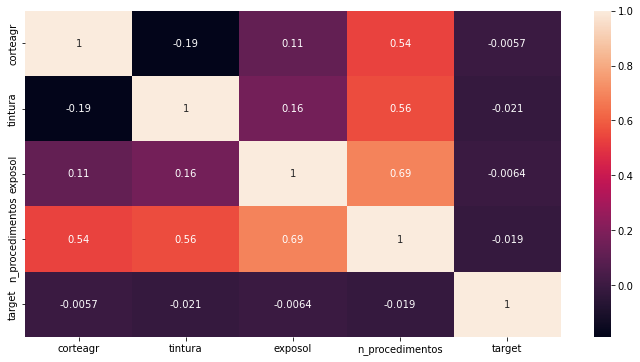

In [ ]:
# Avaliando a correlação entre os procedimentos e a variável target
plt.figure(figsize = (12,6))
sns.heatmap(df.loc[:,['corteagr', 'tintura', 'exposol',
       'n_procedimentos', 'target']].corr(), annot = True)

## UTM Source

In [ ]:
df.utm_source.value_counts()

influencer         125760
facebook            97529
google              35230
sf_wpp_camp         23744
linktree            23052
instagram           20206
sf_email_camp       13875
sf_wpp_flux          8378
rakuten              3023
IGShopping           2927
email_sf             1624
blog                 1295
tiktok                944
microinfluencer       759
adwords               721
site                  604
sf_email_flux         323
incicacao              65
meliuz                 54
salesforce             42
whatsapp               24
sendinblue             17
telegram               17
sf_sms_camp            10
cpc                     4
sf_wpp_flu              4
sms                     4
facebook                3
uaubox                  2
popup                   2
sf_camp_email           2
email                   1
copy_link               1
Facebook ads            1
santander               1
all                     1
teste_source            1
sf_                     1
Name: utm_so

### Agrupando categorias 

In [ ]:
df.loc[df.utm_source=='sf_wpp_flu','utm_source'] = 'sf_wpp_flux'

In [ ]:
df.utm_source = df.utm_source.str.strip()

In [ ]:
df.utm_source.value_counts().sort_values(ascending=False)

influencer         125760
facebook            97532
google              35230
sf_wpp_camp         23744
linktree            23052
instagram           20206
sf_email_camp       13875
sf_wpp_flux          8382
rakuten              3023
IGShopping           2927
email_sf             1624
blog                 1295
tiktok                944
microinfluencer       759
adwords               721
site                  604
sf_email_flux         323
incicacao              65
meliuz                 54
salesforce             42
whatsapp               24
telegram               17
sendinblue             17
sf_sms_camp            10
cpc                     4
sms                     4
sf_camp_email           2
popup                   2
uaubox                  2
email                   1
copy_link               1
Facebook ads            1
santander               1
all                     1
teste_source            1
sf_                     1
Name: utm_source, dtype: int64

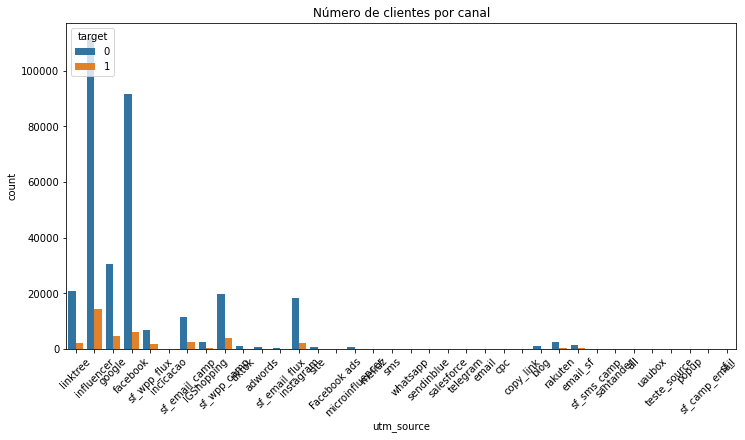

In [ ]:
plt.figure(figsize=(12,6))
plt.title('Número de clientes por canal')
sns.countplot(data = df, x='utm_source', hue = 'target')
plt.xticks(rotation = 45)
plt.show()

#### Instagram

In [ ]:
df.loc[df.utm_source == 'instagram', 'target'].value_counts(normalize = True)

0    0.901217
1    0.098783
Name: target, dtype: float64

In [ ]:
df.loc[df.utm_source == 'IGShopping', 'target'].value_counts(normalize = True)

0    0.839084
1    0.160916
Name: target, dtype: float64

In [ ]:
df.loc[df.utm_source == 'IGShopping', 'utm_source'] = 'instagram'

#### Site

In [ ]:
df.loc[df.utm_source == 'popup', 'utm_source'] = 'site'

In [ ]:
df.loc[df.utm_source == 'blog', 'utm_source'] = 'site'

#### 3rd Parties

In [ ]:
df.loc[df.utm_source == 'meliuz', 'target'].value_counts(normalize = True)

0    0.759259
1    0.240741
Name: target, dtype: float64

In [ ]:
df.loc[df.utm_source == 'salesforce', 'target'].value_counts(normalize = True)

0    0.785714
1    0.214286
Name: target, dtype: float64

In [ ]:
df.loc[df.utm_source == 'sf_', 'target'].value_counts(normalize = True)

0    1.0
Name: target, dtype: float64

In [ ]:
df.loc[df.utm_source == 'sf_sms_camp', 'target'].value_counts(normalize = True)

0    1.0
Name: target, dtype: float64

In [ ]:
df.loc[df.utm_source == 'sendinblue', 'target'].value_counts(normalize = True)

0    0.941176
1    0.058824
Name: target, dtype: float64

In [ ]:
df.loc[df.utm_source == 'sf_', 'utm_source'] = '3rd_parties'
df.loc[df.utm_source == 'meliuz', 'utm_source'] = '3rd_parties'
df.loc[df.utm_source == 'salesforce', 'utm_source'] = '3rd_parties'
df.loc[df.utm_source == 'sf_sms_camp', 'utm_source'] = '3rd_parties'
df.loc[df.utm_source == 'sendinblue', 'utm_source'] = '3rd_parties'
df.loc[df.utm_source == 'uaubox', 'utm_source'] = '3rd_parties'
df.loc[df.utm_source == 'santander', 'utm_source'] = '3rd_parties'
df.loc[df.utm_source == 'cpc', 'utm_source'] = '3rd_parties'
df.loc[df.utm_source == 'incicacao', 'utm_source'] = '3rd_parties'


#### Facebook

In [ ]:
df.loc[df.utm_source == 'Facebook ads', 'utm_source'] = 'facebook'

#### Email

In [ ]:
df.loc[df.utm_source == 'sf_email_camp', 'target'].value_counts(normalize = True)

0    0.828396
1    0.171604
Name: target, dtype: float64

In [ ]:
df.loc[df.utm_source == 'sf_email_camp', 'utm_source'] = 'email'

In [ ]:
df.loc[df.utm_source == 'sf_camp_email', 'utm_source'] = 'email'

In [ ]:
df.loc[df.utm_source == 'email_sf', 'target'].value_counts(normalize = True)

0    0.885468
1    0.114532
Name: target, dtype: float64

In [ ]:
df.loc[df.utm_source == 'email_sf', 'utm_source'] = 'email'

In [ ]:
df.loc[df.utm_source == 'sf_email_flux', 'target'].value_counts(normalize = True)

0    0.804954
1    0.195046
Name: target, dtype: float64

In [ ]:
df.loc[df.utm_source == 'sf_email_flux', 'utm_source'] = 'email'

#### Whatsapp

In [ ]:
df.loc[df.utm_source == 'whatsapp', 'target'].value_counts(normalize = True)

0    0.875
1    0.125
Name: target, dtype: float64

In [ ]:
df.loc[df.utm_source == 'sf_wpp_flux', 'target'].value_counts(normalize = True)

0    0.795037
1    0.204963
Name: target, dtype: float64

In [ ]:
df.loc[df.utm_source == 'sf_wpp_flux', 'utm_source'] = 'whatsapp'

In [ ]:
df.loc[df.utm_source == 'sf_wpp_camp', 'target'].value_counts(normalize = True)

0    0.831789
1    0.168211
Name: target, dtype: float64

In [ ]:
df.loc[df.utm_source == 'sf_wpp_camp', 'utm_source'] = 'whatsapp'

In [ ]:
df.loc[df.utm_source == 'telegram', 'utm_source'] = 'whatsapp'

#### Influencers

In [ ]:
df.loc[df.utm_source == 'microinfluencer', 'target'].value_counts(normalize = True)

0    0.919631
1    0.080369
Name: target, dtype: float64

In [ ]:
df.loc[df.utm_source == 'microinfluencer', 'utm_source'] = 'influencer'

In [ ]:
df.loc[df.utm_source == 'influencer', 'target'].value_counts(normalize = True)

0    0.88729
1    0.11271
Name: target, dtype: float64

In [ ]:
df.dropna(subset=['utm_source'], axis = 0, inplace = True)

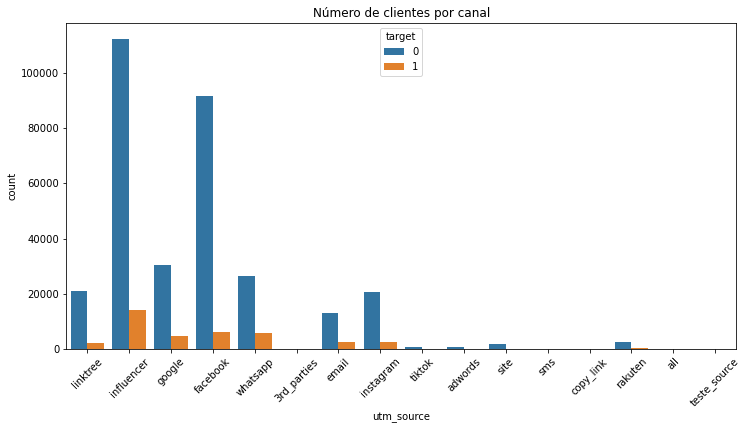

In [ ]:
plt.figure(figsize=(12,6))
sns.countplot(data = df, x='utm_source', hue = 'target')
plt.title('Número de clientes por canal')
plt.xticks(rotation = 45)
plt.show()

### Descarte de categorias

In [ ]:
df.drop((df[(df.utm_source == 'all') | 
            (df.utm_source == 'copy_link') | 
            (df.utm_source == 'teste_source') | 
            (df.utm_source == 'sms')]).index, inplace=True)

In [ ]:
df.columns

Index(['sistema_operacional', 'navegador', 'cidade', 'estado',
       'qtde_lavagem_semana', 'utm_source', 'tipo_cabelo', 'comprimento',
       'tipo_fios', 'procedimentos', 'tempo_procedimento', 'dieta',
       'atividade_fisica', 'frequencia_estresse', 'caracteristica',
       'faixa_etaria', 'efeitos_desejados', 'fragancia', 'target', 'rec_form',
       'rec_compra', 'n_efeitos', 'efeito1', 'efeito2', 'efeito3', 'efeito4',
       'efeito5', 'efeito6', 'efeito7', 'efeito8', 'efeito9', 'efeito10',
       'n_caracteristicas', 'caracteristica1', 'caracteristica2',
       'caracteristica3', 'caracteristica4', 'caracteristica5',
       'caracteristica6', 'caracteristica7', 'caracteristica8',
       'caracteristica9', 'caracteristica10', 'corteagr', 'tintura', 'exposol',
       'n_procedimentos'],
      dtype='object')

In [ ]:
df.drop(['efeitos_desejados','caracteristica','procedimentos'], axis = 1, inplace = True)

In [ ]:
df.drop(['cidade'], axis = 1, inplace = True)

(0.0, 5.0)

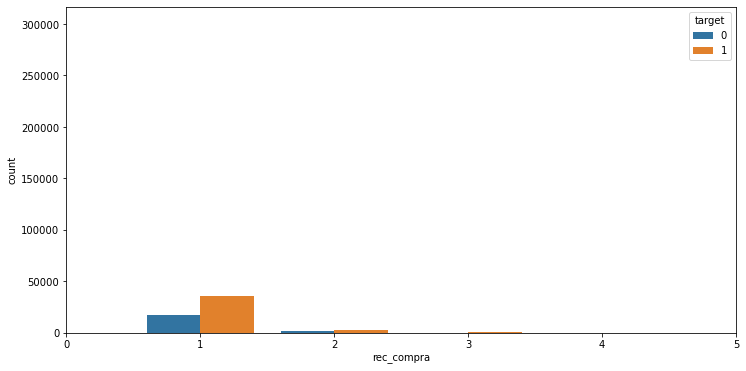

In [158]:
sns.countplot(data=df, x='rec_compra', hue = 'target')
plt.xlim([0,5])

(0.0, 10.0)

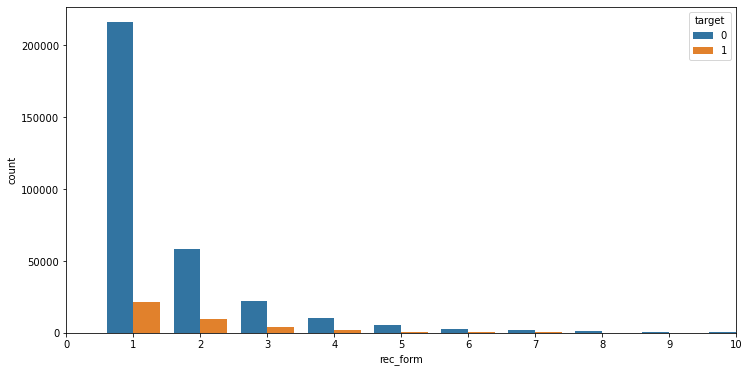

In [157]:
sns.countplot(data=df, x='rec_form', hue = 'target')
plt.xlim([0,10])

# Modelagem

* Foram consideradas todas as features presentes na tabela de forms, onde estão as informações comuns aos leads que compraram ou não, excetuando, inicialmente, dados de identificação e datas de ocorrência. 

* Foi excluída a feature de "Locale" por não ter variabilidade e a feature "navegador" por conter muitos valores faltantes. 

* As features features "cidade" e"estado" também foram excluídas porterem muitas categorias, aumentando a dimensionalidade do dataset devido ao One Hot Encoding e adicionar um viés de região. Além disso, após testes, o resultado do modelo com a feature estado não mostrou melhores resultados.

* As features foram coletadas através de consulta SQL, filtrando todos os dados que estavam presentes na tabela **forms**

* Além disso, foram criadas features para destacar a quantidade de itens contidos nas colunas multilabel como "caracteristica", "procedimento" e "efeito".

In [ ]:
X = df.drop(['target', 'navegador','estado'], axis = 1)
y = df.target.astype('category')

In [ ]:
# Features categóricas ordenáveis e não ordenáveis
ordinal_cols = ['comprimento','faixa_etaria','frequencia_estresse', 'atividade_fisica', 'tempo_procedimento']
ohc_cols     = ['sistema_operacional','tipo_cabelo','tipo_fios','dieta','fragancia', 'utm_source', 'estado'] 

In [ ]:
# Ordem de features ordenáveis

comprimento        = ['Raíz exposta','Muito curto','Longo','Extra longo']
faixa_etaria       = ['2 a 10','11 a 17','18 a 24','25 a 34', '35 a 44', '45 a 54', '55 a 64', '65+']
estresse           = ['Nunca','Uma vez por mês', 'Regularmente', 'Quase sempre']
atividade_fisica   = ['Nunca','N/C','Raramente','Frequente','Sempre']
tempo_procedimento = ['Há 1 semana','Há 2 semanas','Há 1 mês','Há mais de 1 mês','Não houve procedimentos']

## Separação treino e teste

In [124]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2, 
                                                    shuffle = True,
                                                    random_state = 42,
                                                    stratify = y)

In [125]:
X_train.columns

Index(['sistema_operacional', 'qtde_lavagem_semana', 'utm_source',
       'tipo_cabelo', 'comprimento', 'tipo_fios', 'tempo_procedimento',
       'dieta', 'atividade_fisica', 'frequencia_estresse', 'faixa_etaria',
       'fragancia', 'rec_form', 'rec_compra', 'n_efeitos', 'efeito1',
       'efeito2', 'efeito3', 'efeito4', 'efeito5', 'efeito6', 'efeito7',
       'efeito8', 'efeito9', 'efeito10', 'n_caracteristicas',
       'caracteristica1', 'caracteristica2', 'caracteristica3',
       'caracteristica4', 'caracteristica5', 'caracteristica6',
       'caracteristica7', 'caracteristica8', 'caracteristica9',
       'caracteristica10', 'corteagr', 'tintura', 'exposol',
       'n_procedimentos'],
      dtype='object')

Lista de features utilizadas antes do pipeline de transformações e treinamento.

## Feature Selection 

In [ ]:
rfe = RFE(estimator=DecisionTreeClassifier(class_weight = 'balanced'), n_features_to_select=40)

Os testes com feature selection mostraram que os melhores resultados foram atingidos pelo modelo quando todas as features disponíveis foram utilizadas em seu treinamento. Portanto, não foi aplicado o RFE para seleção de features no pipeline do modelo

## Preprocessamento (manual) dos dados

In [ ]:
X = pd.get_dummies(data = X, columns = ohc_cols)

In [242]:
oe                              = OrdinalEncoder(categories = [comprimento, faixa_etaria, estresse, atividade_fisica, tempo_procedimento])
ohc                             = OneHotEncoder(drop = 'first', sparse = False)

# Treino
X_train.loc[:,ordinal_cols]     = oe.fit_transform(X_train[ordinal_cols])
#X_train                         = pd.get_dummies(data = X_train, columns = ohc_cols)

# Teste
X_test.loc[:,ordinal_cols]     = oe.transform(X_test[ordinal_cols])
#X_test                         = pd.get_dummies(data = X_test, columns = ohc_cols)

## Oversampling

In [243]:
oversampler = SMOTE(sampling_strategy=0.3)

In [ ]:
X_train, y_train = oversampler.fit_resample(X_train, y_train)

## Undersampling

In [ ]:
nr = NearMiss()
ru = RandomUnderSampler(sampling_strategy = 0.4)

In [ ]:
X_train, y_train = ru.fit_sample(X_train,y_train)

In [ ]:
X_test, y_test = nr.fit_sample(X_test,y_test)

In [ ]:
y_train.value_counts(normalize=True)

## Baseline

Considerando o disparo feito indiscriminadamente a todos os leads, vamos assumir toda a target como valores positivos.

In [116]:
ones = np.ones_like(y_train)

In [117]:
print('Acurácia: ', round(accuracy_score(y_train, ones)*100,2), "%")
print('Precisão: ', round(precision_score(y_train, ones)*100,2), "%")
print('Recall: ', round(recall_score(y_train, ones)*100,2), "%")
print('f1: ', round(f1_score(y_train, ones)*100,2), "%")
print('ROC-AUC: ', round(roc_auc_score(y_train, ones)*100,2), "%")

Acurácia:  10.75 %
Precisão:  10.75 %
Recall:  100.0 %
f1:  19.41 %
ROC-AUC:  50.0 %


* Em resumo, apesar de todos os usuários compradores serem alcançados, apenas cerca de 11% de todos os disparos se convertem em compra. 
* A pontuação ROC AUC de 50% indicia que o método não possui nenhuma precisão na sua implementação e é simplesmente aleatório.

## Preparação Pipeline

As técnicas de undersampling e oversampling nao foram eficientes na avaliação dos dados de teste e por isso não foram aplicadas no pipeline.

In [127]:
# Definição de transformadores ordinais e One-Hot-Enconding para variáveis categóricas e scaling para variáveis numéricas.
col_transf = ColumnTransformer(transformers = [('ordinal', OrdinalEncoder(categories = [comprimento, faixa_etaria, estresse, atividade_fisica, tempo_procedimento]), ['comprimento','faixa_etaria','frequencia_estresse', 'atividade_fisica', 'tempo_procedimento']),
                                               ('OHC', OneHotEncoder(drop = 'first'), ['sistema_operacional','tipo_cabelo','tipo_fios','dieta','fragancia', 'utm_source']),
                                               ('Scaling', MinMaxScaler(), ['qtde_lavagem_semana','n_efeitos','n_caracteristicas', 'n_procedimentos'])]) 

Etapas do pipeline: 
* Encoding de ordenação nas variáveis de comprimento do cabelo, faixa etária, estresse, frequencia de atividade física e tempo desde o último procedimento;
* One-hot-Encoding das variáveis de sistema operacional, tipo de cabelo, tipo de fios, dieta, fragancia, estado, e fonte de informação.
* Normalização/Scaling das variáveis numérica de quantidade semanal de lavagens, numero de efeitos desejados, numero de procedimentos e numero de características no cabelo

In [128]:
# Coeficiente de penalidade pelo desbalanceamento de classes no algoritmo XGBOOST
counter = Counter(y_train)
estimate = counter[0] / counter[1]
estimate

8.296912803638827

In [216]:
skfold = StratifiedKFold(n_splits=3, shuffle = True, random_state = 42)

models = [LogisticRegression(class_weight = {0:.1, 1:.9}),
          #KNeighborsClassifier(),
          #GaussianNB(),
          #SVC(class_weight={0:.2, 1:0.8}),
          DecisionTreeClassifier(class_weight = {0:.1, 1:.9}),
          ExtraTreeClassifier(class_weight = {0:.1, 1:.9}),
          RandomForestClassifier(class_weight = {0:.1, 1:.9}),
          XGBClassifier(scale_pos_weight = estimate),
          #AdaBoostClassifier(class_weights = {0:.1, 1:.9}),
          CatBoostClassifier(class_weights = {0:.1, 1:.9})]

Foi aplicado uma validação cruzada estratificada para garantir que os dados separados preservem o desbalanceamento entre as classes target.

## Model Selection

* Dada a natureza do problema, foram selecionados algoritmos de classificação entre modelos lineares e não-lineares e ensembles para avaliação da melhor performance.
* Em todos os modelos em que foi possível, foi realizado um balanceamento da classe target modificando o peso da penalidade por erro em cada classe. Seguindo o que foi visto na distribuição da classe target, os pesos foram de aprox 10% para a classe 0 e 90% para a classe 1.
* As técnicas de oversampling e undersampling não produziram bons resultados na testagem.

In [ ]:
model_scores = []

for model in tqdm(models):
    
    pipe = Pipeline([('encoding', col_transf),
                     ('clf', model)])

    scores = cross_validate(pipe, X_train, y_train, cv = skfold, scoring = ['precision','recall','f1','roc_auc'])
    
    model_scores.append([model, 
                         (round(scores['test_roc_auc'].mean(),2), ' +- ', round(scores['test_roc_auc'].std(),2)), 
                         (round(scores['test_f1'].mean(),2), ' +- ', round(scores['test_f1'].std(),2)) , 
                         (round(scores['test_precision'].mean(),2), ' +- ', round(scores['test_precision'].std(),2)),
                         (round(scores['test_recall'].mean(),2), ' +- ', round(scores['test_recall'].std(),2))
                        ])

model_results = pd.DataFrame(model_scores, columns = ['model','roc_auc','f1', 'precision','recall'])

Para este case, como a meta principal é a redução de custos com disparos de maneira assertiva, a principal métrica avaliada para qualidade do modelo foi a AUC da curva ROC qie avalia a performance considerando a taxa de positivos falsos e verdadeiros.

In [219]:
model_results[['model','roc_auc','f1','precision','recall']].sort_values(by=['roc_auc','f1'], ascending = False)

,model,roc_auc,f1,precision,recall
0,"LogisticRegression(class_weight={0: 0.1, 1: 0.9})","(0.67, +- , 0.0)","(0.26, +- , 0.0)","(0.16, +- , 0.0)","(0.67, +- , 0.01)"
4,"XGBClassifier(base_score=None, booster=None, c...","(0.67, +- , 0.0)","(0.26, +- , 0.0)","(0.17, +- , 0.0)","(0.6, +- , 0.0)"
5,<catboost.core.CatBoostClassifier object at 0x...,"(0.66, +- , 0.0)","(0.26, +- , 0.0)","(0.16, +- , 0.0)","(0.63, +- , 0.0)"
3,"RandomForestClassifier(class_weight={0: 0.1, 1...","(0.61, +- , 0.0)","(0.04, +- , 0.0)","(0.1, +- , 0.0)","(0.02, +- , 0.0)"
1,"DecisionTreeClassifier(class_weight={0: 0.1, 1...","(0.51, +- , 0.0)","(0.14, +- , 0.0)","(0.13, +- , 0.0)","(0.16, +- , 0.0)"
2,"ExtraTreeClassifier(class_weight={0: 0.1, 1: 0...","(0.51, +- , 0.0)","(0.14, +- , 0.0)","(0.13, +- , 0.0)","(0.15, +- , 0.0)"


* Os algoritmos que melhor performaram foram a **Regressão Logística**, **XGBoost** e **Catboost**.
* Considerando que o algoritmo de regressão logísitca é mais simples e ainda atingiu a melhor performance, será o modelo com maior potencial para entrar em produção.
* Os modelos não tiveram variações nos resultados durante o cross-validation, o que indica variância baixa, possivelmente devido à quantidade de dados disponíveis para elaboração do modelo.


## Tunagem de Hiperpârametros

### Logistic Regression

In [129]:
pipe = Pipeline([('encoding', col_transf),
                ('clf', LogisticRegression())])

In [130]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('encoding',
                 ColumnTransformer(transformers=[('ordinal',
                                                  OrdinalEncoder(categories=[['Raíz '
                                                                              'exposta',
                                                                              'Muito '
                                                                              'curto',
                                                                              'Longo',
                                                                              'Extra '
                                                                              'longo'],
                                                                             ['2 '
                                                                              'a '
                                                                              '10',
                                                 

In [280]:
weights = np.linspace(.9,.99,200)
param_grid = {'clf__class_weight': [{0:(1-w1), 1:w1} for w1 in weights],
              'clf__C': [1,1.5,2.5,3,3.5,4],
              'clf__max_iter':[100,200,300,400]}

Foram testadiferentes variações de balanceamento de classes, parametro de regularização e o número de iterações máximas para convergência da função de perda do algoritmo.

In [281]:
rsearch = RandomizedSearchCV(pipe, param_grid, scoring = 'roc_auc', cv = skfold, n_iter = 50)

In [ ]:
rsearch.fit(X_train, y_train)

In [286]:
print('Melhores parametros: ', rsearch.best_params_,'\nMelhor AUC-Score: ', rsearch.best_score_)

Melhores parametros:  {'clf__max_iter': 300, 'clf__class_weight': {0: 0.06924623115577888, 1: 0.9307537688442211}, 'clf__C': 3} 
Melhor AUC-Score:  0.6679754104194146


##  Testagem

In [131]:
pipe = Pipeline([('encoding', col_transf),
                ('clf', LogisticRegression(max_iter = 300, 
                                           class_weight = {0: 0.06924623115577888, 1: 0.9307537688442211}, 
                                           C=3
                ))])

In [132]:
pipe.fit(X_train, y_train)
print()

### Matriz de confusão

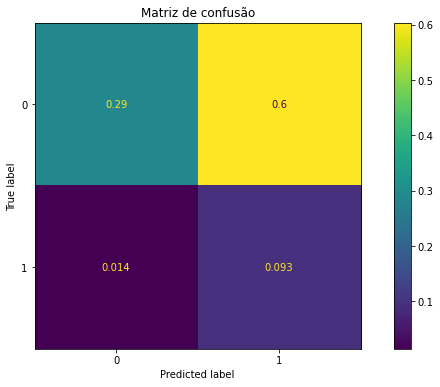

In [136]:
plot_confusion_matrix(pipe, X_test, y_test, normalize = 'all')
plt.title('Matriz de confusão')
plt.show()

In [135]:
X_test.columns

Index(['sistema_operacional', 'qtde_lavagem_semana', 'utm_source',
       'tipo_cabelo', 'comprimento', 'tipo_fios', 'tempo_procedimento',
       'dieta', 'atividade_fisica', 'frequencia_estresse', 'faixa_etaria',
       'fragancia', 'rec_form', 'rec_compra', 'n_efeitos', 'efeito1',
       'efeito2', 'efeito3', 'efeito4', 'efeito5', 'efeito6', 'efeito7',
       'efeito8', 'efeito9', 'efeito10', 'n_caracteristicas',
       'caracteristica1', 'caracteristica2', 'caracteristica3',
       'caracteristica4', 'caracteristica5', 'caracteristica6',
       'caracteristica7', 'caracteristica8', 'caracteristica9',
       'caracteristica10', 'corteagr', 'tintura', 'exposol',
       'n_procedimentos'],
      dtype='object')

* O resultado do teste mostra que há 87% de acerto no disparo de mensagens para leads compradores. 
* Ao mesmo tempo, o resultado é alcançado com cerca de 29% a menos de mensagens enviadas para leads não compradores.

### Curva ROC

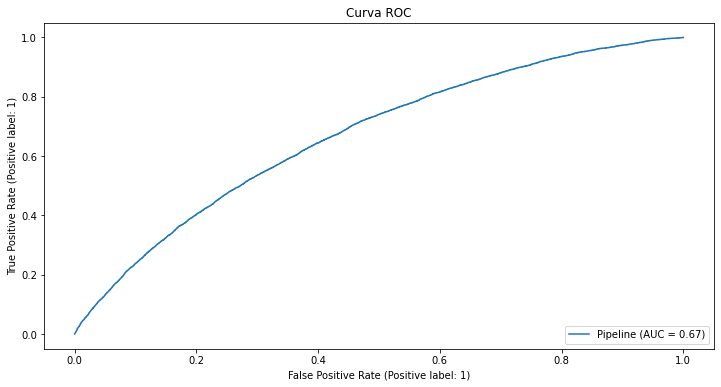

In [456]:
plot_roc_curve(pipe,X_test, y_test)
plt.title('Curva ROC')
plt.show()

* O modelo atingiu a métrica de 67% na métrica de ponderação (AUC) entre leads compradores e leads não compradores que receberão mensagens. O resultado é um acréscimo de 17% em relação ao que era realizado inicialmente.

In [453]:
y_pred = pipe.predict(X_test)

In [454]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.32      0.48     64206
           1       0.13      0.87      0.23      7748

    accuracy                           0.38     71954
   macro avg       0.54      0.60      0.36     71954
weighted avg       0.86      0.38      0.45     71954



## Importância de Features

In [380]:
r = permutation_importance(pipe, X_test, y_test,
                           n_repeats=30,
                           random_state=0)

In [381]:
for i in r.importances_mean.argsort()[::-1]:
        if r.importances_mean[i]  >0:
            print(f"{X_train.columns[i]:<8}"
                  f"{r.importances_mean[i]:.3f}"
                  f" +/- {r.importances_std[i]:.3f}")

utm_source0.019 +/- 0.001
sistema_operacional0.009 +/- 0.001
faixa_etaria0.005 +/- 0.001
dieta   0.003 +/- 0.001
n_efeitos0.001 +/- 0.001
tipo_cabelo0.001 +/- 0.000
n_caracteristicas0.001 +/- 0.000
tempo_procedimento0.000 +/- 0.000
tipo_fios0.000 +/- 0.000
frequencia_estresse0.000 +/- 0.000
qtde_lavagem_semana0.000 +/- 0.000


In [384]:
p_imp = pd.Series(r.importances_mean, index = X_test.columns)
p_imp.sort_values(ascending = False, inplace = True)

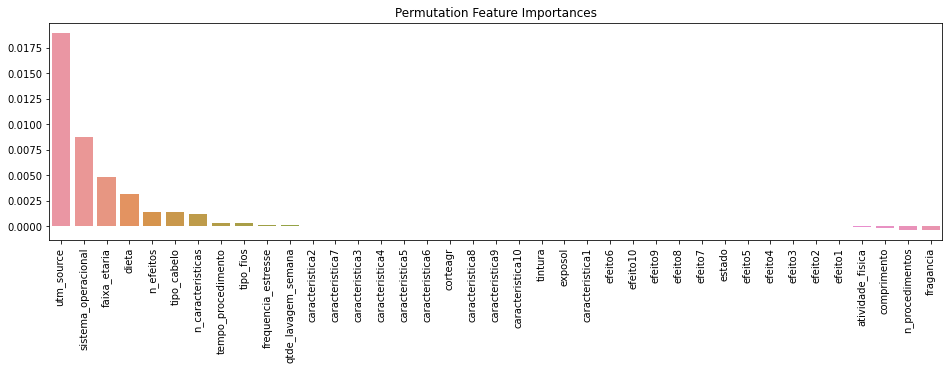

In [385]:
plt.figure(figsize=(16,4))
sns.barplot(x=p_imp.index, y= p_imp.values)
plt.xticks(rotation = 90)
plt.title('Permutation Feature Importances')
plt.show()

As features tem pouco poder preditivo isoladamente, sendo as features de canal de contato e faixa etária as mais representativas com menos de 2% de explicabilidade cada.

## Resultado Econômico do projeto 

* A média de preço por disparo no WhatsApp é de cerca de R\\$ 0.12. Considerando que por mês, em média, são preenchidos 72.000 formulários, o aumento na assertividade dos disparos com a redução de 29% nos envios pode gerar uma economia de R\\$ 2.505,60/mês para a empresa, mantendo ainda uma taxa de acerto nos disparos de 87% para leads que são compradores.

# Gerando arquivo pkl do modelo

In [430]:
with open('../model.pkl', 'wb') as file:
    pickle.dump(pipe, file)